# <a name="0">Machine Learning Lab

Build a classfier to predict the __label__ field (substitute or not substitute) of the product substitute dataset.

### Final Project Problem: Product Substitute Prediction

__Problem Definition__:
Given a pair of products, (A, B), we say that B is a "substitute" for A if a customer would buy B in place of A -- say, if A were out of stock.

The goal of this project is to predict a substitute relationship between pairs of products. Complete the tasks in this notebook and submit your notebook via Colab  

1. <a href="#1">Read the datasets</a> (Given)
2. <a href="#2">Data Processing</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a> (Suggested)
    * <a href="#23">Train - Validation - Test Datasets</a>
    * <a href="#24">Data Processing with Pipeline</a>
3. <a href="#3">Train (and Tune) a Classifier on the Training Dataset</a> (Implement)
4. <a href="#3">Make Predictions on the Test Dataset</a> (Implement)


__Datasets and Files:__


* __training.csv__: Training data with product pair features and corresponding labels:
> - `ID:` ID of the record
> - `label:` Tells whether the key and candidate products are substitutes (1) or not (0).
> - `key_asin ...:` Key product ASIN features
> - `cand_asin ...:` Candidate product ASIN features


* __public_test_features.csv__: Test data with product pairs features __without__ labels:
> - `ID:` ID of the record
> - `key_asin ...:` Key product ASIN features
> - `cand_asin ...:` Candidate product ASIN features


* __metadata-dataset.xlsx__: Provides detailed information about all key_ and cand_ columns in the training and test sets. Try to select some useful features to include in the model, as not all of them are suitable. `|Region Id|MarketPlace Id|ASIN|Binding Code|binding_description|brand_code|case_pack_quantity|, ...`


In [33]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)
</br>
<a href="https://propensity-labs-screening.s3.amazonaws.com/machine_learning/ml_data.zip">Download Dataset</a>

In [2]:
!wget https://propensity-labs-screening.s3.amazonaws.com/machine_learning/ml_data.zip
!unzip ml_data.zip

--2024-03-23 14:36:38--  https://propensity-labs-screening.s3.amazonaws.com/machine_learning/ml_data.zip
Resolving propensity-labs-screening.s3.amazonaws.com (propensity-labs-screening.s3.amazonaws.com)... 3.5.8.148, 3.5.25.48, 52.217.134.153, ...
Connecting to propensity-labs-screening.s3.amazonaws.com (propensity-labs-screening.s3.amazonaws.com)|3.5.8.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16176444 (15M) [application/zip]
Saving to: ‘ml_data.zip’

ml_data.zip         100%[===================>]  15.43M  11.4MB/s    in 1.4s    

2024-03-23 14:36:40 (11.4 MB/s) - ‘ml_data.zip’ saved [16176444/16176444]

Archive:  ml_data.zip
   creating: ml_data/
  inflating: __MACOSX/._ml_data      
  inflating: ml_data/training.csv    
  inflating: __MACOSX/ml_data/._training.csv  
  inflating: ml_data/metadata-dataset.xlsx  
  inflating: __MACOSX/ml_data/._metadata-dataset.xlsx  
  inflating: ml_data/public_test_features.csv  
  inflating: __MACOSX/ml_data/._pub

In [65]:
df = pd.read_csv('/content/ml_data/training.csv')
test_data = pd.read_csv('/content/ml_data/public_test_features.csv')

cols = ['key_product_type', 'key_item_height', 'key_item_length',
        'key_item_weight', 'key_item_width', 'cand_product_type',
        'cand_item_height','cand_item_length', 'cand_item_weight',
        'cand_item_width']
wdf = df[cols]
test_data = test_data[cols]

wdf['label'] = df['label']

<ipython-input-65-857630f41aa7>:1: DtypeWarning: Columns (34,139,154,157,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/ml_data/training.csv')
<ipython-input-65-857630f41aa7>:2: DtypeWarning: Columns (134,138,156,197,211) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('/content/ml_data/public_test_features.csv')
<ipython-input-65-857630f41aa7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdf['label'] = df['label']


In [66]:
# Utility dictionary to transform product IDs
if os.path.exists('transform.pkl'):
  with open('transform.pkl', 'rb+') as f:
    transform = pickle.load(f)
else:
  kpt = list(sorted(df['key_product_type'].unique()))
  for i in sorted(df['cand_product_type'].unique()):
    kpt.append(i)
  kpt = list(set(kpt))
  for i in sorted(test_data['cand_product_type'].unique()):
    kpt.append(i)
  kpt = list(set(kpt))
  transform = {}
  c = 0
  for i in kpt:
    transform[i] = c
    c+=1
  with open('transform.pkl', 'wb+') as f:
    pickle.dump(transform, f)

Then, we read the __training__ and __test__ datasets into dataframes

## 2. <a name="2">Data Processing</a> (Implement)
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>

We look at number of rows, columns, and some simple statistics of the datasets.

In [36]:
wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36803 entries, 0 to 36802
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key_product_type   36803 non-null  object 
 1   key_item_height    26453 non-null  float64
 2   key_item_length    26453 non-null  float64
 3   key_item_weight    22635 non-null  float64
 4   key_item_width     26453 non-null  float64
 5   cand_product_type  36803 non-null  object 
 6   cand_item_height   21865 non-null  float64
 7   cand_item_length   21865 non-null  float64
 8   cand_item_weight   19191 non-null  float64
 9   cand_item_width    21865 non-null  float64
 10  label              36803 non-null  int64  
dtypes: float64(8), int64(1), object(2)
memory usage: 3.1+ MB


In [37]:
wdf['key_product_type'] = wdf['key_product_type'].apply(lambda x: transform[x])
wdf['cand_product_type'] = wdf['cand_product_type'].apply(lambda x: transform[x])

<ipython-input-37-3c0c9fe63d5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdf['key_product_type'] = wdf['key_product_type'].apply(lambda x: transform[x])
<ipython-input-37-3c0c9fe63d5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdf['cand_product_type'] = wdf['cand_product_type'].apply(lambda x: transform[x])


In [38]:
wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36803 entries, 0 to 36802
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key_product_type   36803 non-null  int64  
 1   key_item_height    26453 non-null  float64
 2   key_item_length    26453 non-null  float64
 3   key_item_weight    22635 non-null  float64
 4   key_item_width     26453 non-null  float64
 5   cand_product_type  36803 non-null  int64  
 6   cand_item_height   21865 non-null  float64
 7   cand_item_length   21865 non-null  float64
 8   cand_item_weight   19191 non-null  float64
 9   cand_item_width    21865 non-null  float64
 10  label              36803 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 3.1 MB


(array([18214.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 18589.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

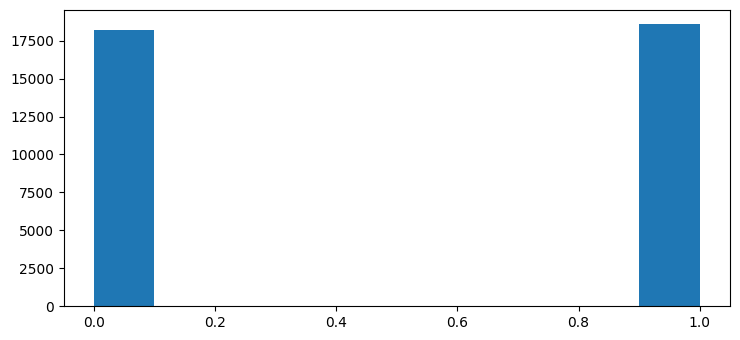

In [39]:
# Implement EDA here
plt.hist(wdf['label'])

- Label histogram indicates normal (non-skewed) distribution of data.

array([<Axes: title={'center': 'cand_product_type'}>], dtype=object)

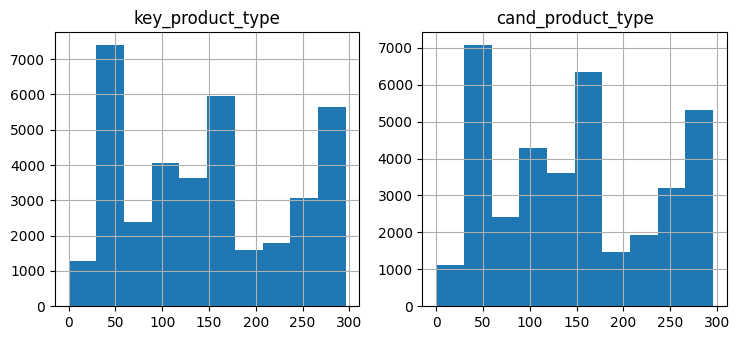

In [40]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 2)

wdf.hist('key_product_type', ax = axes[0])
wdf.hist('cand_product_type', ax = axes[1])

- Similar trend in key product and candidate product is interesting.
- Taking one of the features as (key_product_type - cand_product_type) could boost results.

### 2.2 <a name="22">Select features to build the model</a>

For a quick start, we recommend using only a few of the numerical features for both key_ and cand_ ASINs: __item_package_quantity__, __item_height__, __item_width__, __item_length__, __item_weight__, __pkg_height__, __pkg_width__, __pkg_length__, __pkg_weight__. Feel free to explore other fields from the metadata-dataset.xlsx file.


<ipython-input-41-a6ef212ce899>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdf['type_change'] = wdf['key_product_type'] - wdf['cand_product_type']


<Axes: >

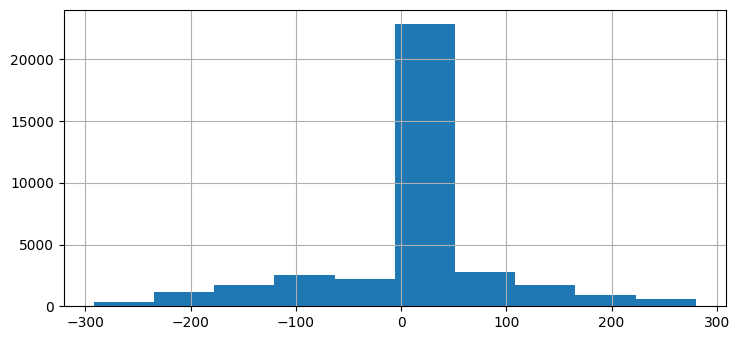

In [41]:
wdf['type_change'] = wdf['key_product_type'] - wdf['cand_product_type']
wdf['type_change'].hist()

- Using the difference in types could possibly lead to better results

In [42]:
# Splitting data into features (X) and labels (y)
X = wdf.drop(['label'], axis = 1)
y = wdf['label']

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36803 entries, 0 to 36802
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key_product_type   36803 non-null  int64  
 1   key_item_height    26453 non-null  float64
 2   key_item_length    26453 non-null  float64
 3   key_item_weight    22635 non-null  float64
 4   key_item_width     26453 non-null  float64
 5   cand_product_type  36803 non-null  int64  
 6   cand_item_height   21865 non-null  float64
 7   cand_item_length   21865 non-null  float64
 8   cand_item_weight   19191 non-null  float64
 9   cand_item_width    21865 non-null  float64
 10  type_change        36803 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 3.1 MB


In [44]:
X.head()

,key_product_type,key_item_height,key_item_length,key_item_weight,key_item_width,cand_product_type,cand_item_height,cand_item_length,cand_item_weight,cand_item_width,type_change
0,267,1.00,86.00,6.000000,66.00,205,0.00000,40.0000,0.530000,18.00000,62
1,155,2.00,2.50,NaN,0.10,116,0.30000,6.7500,0.110231,4.50000,39
2,187,0.83,5.94,0.789375,2.24,98,0.86614,2.3622,0.396832,3.62204,89
3,230,NaN,NaN,NaN,NaN,192,2.36000,10.2400,3.480000,20.29000,38
4,139,9.33,2.75,0.438000,7.50,139,8.50000,11.7500,NaN,9.87500,0


In [45]:
X[X.isna().any(axis=1)]

,key_product_type,key_item_height,key_item_length,key_item_weight,key_item_width,cand_product_type,cand_item_height,cand_item_length,cand_item_weight,cand_item_width,type_change
1,155,2.00,2.50,NaN,0.10,116,0.30,6.75,0.110231,4.500,39
3,230,NaN,NaN,NaN,NaN,192,2.36,10.24,3.480000,20.290,38
4,139,9.33,2.75,0.438000,7.50,139,8.50,11.75,NaN,9.875,0
6,187,1.97,4.72,0.040000,0.39,187,4.00,8.50,NaN,5.000,0
8,267,2.00,5.00,1.000000,4.00,267,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
36795,185,NaN,NaN,NaN,NaN,160,NaN,NaN,0.450000,NaN,25
36796,270,8.50,14.06,18.920000,15.00,155,8.00,15.00,NaN,4.000,115
36799,166,7.00,11.88,0.881849,11.06,166,9.50,13.12,NaN,12.370,0
36800,154,NaN,NaN,NaN,NaN,269,NaN,NaN,7.000000,NaN,-115


- Too many NaN values. Filled them with key_product_type average and cand_product_type average.

### 2.3 <a name="23">Train - Validation Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We already have training and test datasets, however the test dataset is missing the labels - the goal of the project is to predict these labels.

To produce a validation set to evaluate model performance before submitting  split the training dataset into train and validation. Validation data you get here will be used later in section 3 to tune your classifier.

### 2.4 <a name="24">Data processing with Pipeline</a>

Build a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)  to impute the missing values and scale the numerical features, and finally train the classifier on the imputed and scaled dataset.


In [46]:
# Filling NaN values with their product type averages for candidate products
def remove_cand_NaN(df):
  ls = []
  for i in df['cand_product_type'].unique():
    ls.append(df[df['cand_product_type'] == i])

  for data in ls:
    for col in ['cand_item_height', 'cand_item_length', 'cand_item_weight', 'cand_item_width']:
      data[col].fillna(data[col].mean(), inplace = True)
  return pd.concat(ls)
# Filling NaN values with their product type averages for key products
def remove_key_NaN(df):
  ls = []
  for i in X['key_product_type'].unique():
    ls.append(df[df['key_product_type'] == i])

  for data in ls:
    for col in ['key_item_height', 'key_item_length', 'key_item_weight', 'key_item_width']:
      data[col].fillna(data[col].mean(), inplace = True)
  return pd.concat(ls)

In [47]:
X = remove_cand_NaN(X)
X = remove_key_NaN(X)
X.fillna(0, inplace = True)

<ipython-input-46-0045846c2b78>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].fillna(data[col].mean(), inplace = True)
<ipython-input-46-0045846c2b78>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].fillna(data[col].mean(), inplace = True)


In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36803 entries, 0 to 36522
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key_product_type   36803 non-null  int64  
 1   key_item_height    36803 non-null  float64
 2   key_item_length    36803 non-null  float64
 3   key_item_weight    36803 non-null  float64
 4   key_item_width     36803 non-null  float64
 5   cand_product_type  36803 non-null  int64  
 6   cand_item_height   36803 non-null  float64
 7   cand_item_length   36803 non-null  float64
 8   cand_item_weight   36803 non-null  float64
 9   cand_item_width    36803 non-null  float64
 10  type_change        36803 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 3.4 MB


- Shouldn't contain any NaN values

In [59]:
# Splitting data into training and validation set

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Uncomment following line and comment Xtest line to train model with validation set.
# Xtrain, ytrain = X, y

# Using StandardScaler for transforming data

s_train = StandardScaler()
Xtrain = s_train.fit_transform(Xtrain)
Xtest = s_train.transform(Xtest)

In [51]:
# Implement here
# The transformations I made were too complex to use Sci-Kit Learn's Pipeline functionality.

## 3. <a name="3">Train (and Tune) a Classifier</a> (Implement)
(<a href="#0">Go to top</a>)

Train and tune the classifier

In [61]:
# Using a voting classifier model which includes HistGradientBoostingClassifier, LogisticRegression, RandomForestClassifier and
# AdaBoostClassifier

estimators = []
estimators.append(('XGBoost', HistGradientBoostingClassifier()))
estimators.append(('LR', LogisticRegression()))
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('AB', AdaBoostClassifier()))
classifier = VotingClassifier(estimators = estimators, voting = 'hard')
classifier.fit(Xtrain, ytrain)

VotingClassifier(estimators=[('XGBoost', HistGradientBoostingClassifier()),
                             ('LR', LogisticRegression()),
                             ('RF', RandomForestClassifier()),
                             ('AB', AdaBoostClassifier())])

In [54]:
ypred = classifier.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.51      0.42      0.46      3637
           1       0.52      0.61      0.56      3724

    accuracy                           0.51      7361
   macro avg       0.51      0.51      0.51      7361
weighted avg       0.51      0.51      0.51      7361



In [62]:
# run this cell only to save trained model.
with open('trained_model.pkl', 'wb+') as f:
  pickle.dump(classifier, f)

## 4. <a name="4">Make Predictions on the Test Dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the trained classifier to predict the labels on the test set. Test accuracy would be displayed upon a valid submission to the leaderboard.

In [67]:
s_test = StandardScaler() # Scaler for testing data
# transforming testing set for prediction
test_data['key_product_type'] = test_data['key_product_type'].apply(lambda x: transform[x])
test_data['cand_product_type'] = test_data['cand_product_type'].apply(lambda x: transform[x])
test_data['type_change'] = test_data['key_product_type'] - test_data['cand_product_type']
test_data = remove_key_NaN(test_data)
test_data = remove_cand_NaN(test_data)
test_data.fillna(0, inplace = True)
test_data = s_test.fit_transform(test_data)

<ipython-input-46-0045846c2b78>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].fillna(data[col].mean(), inplace = True)
<ipython-input-46-0045846c2b78>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].fillna(data[col].mean(), inplace = True)


In [68]:
# Loading model for predicting test data
with open('trained_model.pkl', 'rb+') as f:
  model = pickle.load(f)
test_pred = model.predict(test_data)

(array([13839.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1935.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

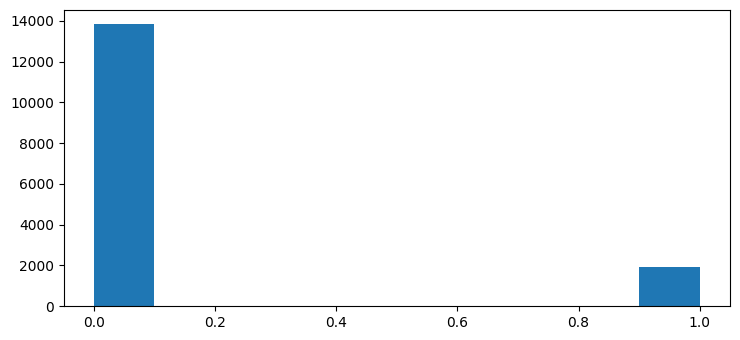

In [69]:
# Visualizing results. NaN values in test set affect results.
plt.hist(test_pred)